## Prompt Optimization 
- Method: Self-Evaluation with Binary Classification
- Data: 직접 라벨링한 데이터
- Frame work:

![](https://private-user-images.githubusercontent.com/149789510/398628973-1d524ee6-dd1e-422b-aed1-9ae880243ac9.png?jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmF3LmdpdGh1YnVzZXJjb250ZW50LmNvbSIsImtleSI6ImtleTUiLCJleHAiOjE3MzUyMTI1NzYsIm5iZiI6MTczNTIxMjI3NiwicGF0aCI6Ii8xNDk3ODk1MTAvMzk4NjI4OTczLTFkNTI0ZWU2LWRkMWUtNDIyYi1hZWQxLTlhZTg4MDI0M2FjOS5wbmc_WC1BbXotQWxnb3JpdGhtPUFXUzQtSE1BQy1TSEEyNTYmWC1BbXotQ3JlZGVudGlhbD1BS0lBVkNPRFlMU0E1M1BRSzRaQSUyRjIwMjQxMjI2JTJGdXMtZWFzdC0xJTJGczMlMkZhd3M0X3JlcXVlc3QmWC1BbXotRGF0ZT0yMDI0MTIyNlQxMTI0MzZaJlgtQW16LUV4cGlyZXM9MzAwJlgtQW16LVNpZ25hdHVyZT1jZWRmYjIzMDczNDM2ZGNhMDY1YTlhNDRmZTIwOGRiMzk3NTFlMmNlYmM4NTA5NTE2YTkyZjA5MjhmMjQzNjBhJlgtQW16LVNpZ25lZEhlYWRlcnM9aG9zdCJ9.PGe91I0PJDmyGwptojP_WKEiYSx-xOQI-P6UuC1LlJI)



In [31]:
import pandas as pd
with open('./filtered_data.csv', 'rb') as file:
    content = file.read().decode('euc-kr', errors='ignore')  # 디코딩 오류를 무시하고 파일 읽기
    from io import StringIO
    data = pd.read_csv(StringIO(content))

data.head()

,videoTitle,parentComment,have_spam
0,[동앵과 뉴스터디] ‘민주당 돈봉투’ 이제 송영길만 남았다? 검찰 “징역 9년 구형...,{'text': '??동앵과 뉴스터디 전체 시리즈 보기 [클릭] \r<br><a h...,0
1,나는 성격이 급해서...일상인걸..ㅋ#커피 #언니뽕 #꿀잼 #웃긴영상 #웃긴짤,{'text': '그럴거면 제로로 시켜야지 cㅂㅏㄹㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 아니 이 ...,0
2,(풀영상) '김건희 류희림 용산 예산' 모두 삭감!!! 펄쩍 뛰는 국민의힘,"{'text': '구독과 좋아요 JTV뉴스를 응원해주세요 감사합니다', 'autho...",0
3,뭔가 이상한 이어폰 케이스 레전드ㅋㅋㅋㅋ,"{'text': '키티 개웃기땄빱빱빱빱빱빱빱빱', 'author': '@arongs...",0
4,자꾸 누워서 살아남은 레전드 동물 ㅋㅋㅋ,"{'text': '동물이 편하게 누움 : 200% ㅈㄴ 개안전함', 'author'...",0


C:\Users\한석호\AppData\Local\Temp\ipykernel_17648\1276598891.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='have_spam', data=data, palette='viridis')  # 축 지정과 팔레트 추가


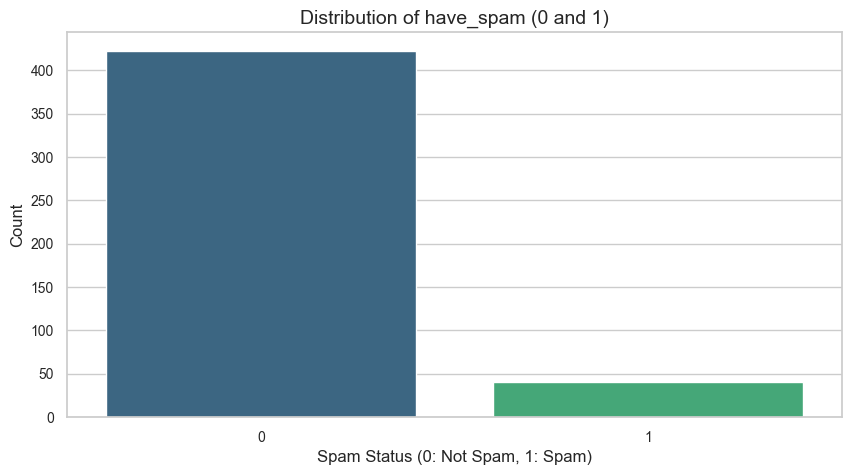

In [32]:
# have_spam 열의 0, 1 개수 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 스타일 설정 (선택 사항)
sns.set(style="whitegrid")

# 데이터 시각화
plt.figure(figsize=(10, 5))
sns.countplot(x='have_spam', data=data, palette='viridis')  # 축 지정과 팔레트 추가
plt.title('Distribution of have_spam (0 and 1)', fontsize=14)  # 그래프 제목 추가
plt.xlabel('Spam Status (0: Not Spam, 1: Spam)', fontsize=12)  # x축 레이블
plt.ylabel('Count', fontsize=12)  # y축 레이블
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [33]:
from ollama import chat
from pydantic import BaseModel
import json
initial_prompt =   (
        "You are a content moderation assistant. Your task is to classify the given comment set as either 'Spam' or 'Not Spam'. "
        "Spam comments include promotional content, irrelevant links, repetitive phrases, or any content that is deceptive, inappropriate, or violates community guidelines. "
        "Not Spam comments are genuine, relevant, and contribute meaningfully to the discussion. "
        "If even one comment in the set is Spam, classify the entire set as Spam. "
        "Consider the author's name as well in your decision. "
        "The response must follow this format exactly. If it deviates, it will result in an error. "
    )
# 댓글 분류를 위한 데이터 모델 정의
class CommentClassification(BaseModel):
    classification: str



# 댓글 분류 함수 정의
def classify_comment(comment: str, generated_prompt: str = initial_prompt) -> CommentClassification:

    config_prompt = (
        f"Comment set:\n{comment}\n\n"
        "If Set has Spam classify as 1, if not spam, classify as 0!\n"
        "Provide the classification in JSON format as follows:\n"
        "{\n"
        '  "classification": "[0/1]"\n'
        "}\n"
    )
    prompt = generated_prompt + config_prompt
    try:
        # Ollama API를 통해 채팅 실행
        response = chat(
            messages=[{'role': 'user', 'content': prompt}],
            model='gemma2',  # 사용할 모델 지정
            format='json',  # 형식을 'json'으로 설정
        )
        
        # 응답 데이터 확인 및 JSON 파싱
        if isinstance(response, dict) and 'message' in response and 'content' in response['message']:
            raw_content = response['message']['content']
            parsed_response = json.loads(raw_content)
            classification = CommentClassification(**parsed_response)
            return classification
        else:
            print(f"올바르지 않은 응답 형식: {response}")
            return None
    except json.JSONDecodeError as e:
        print(f"JSON 파싱 오류: {e}")
        return None
    except Exception as e:
        print(f"분류 중 오류 발생: {e}")
        return None


In [34]:
def generate_evaluation(eval_data: str) -> str:
    # comments와 분류 결과 그리고 정답을 함께 넣어 reasoning을 작성하도록 하는 코드
    prompt = (
        f"""
        You are an expert in binary classification evaluation. Based on the provided evaluation data, generate a detailed reasoning to explain the classification results. 
        The evaluation data includes:
        1. The predicted labels from the model.
        2. The ground truth labels.
        3. Any additional comments or observations on the dataset.

        Your reasoning should include:
        - A summary of the overall classification performance.
        - Identification of specific patterns or errors in the predictions.
        - Suggestions for improving model performance.

        Here is the evaluation data:
        {eval_data}
        """
    )
    reason = chat(
        messages=[{'role': 'user', 'content': prompt}],
        model='gemma2'  # 사용할 모델 지정
    )
    
    return reason
    

In [35]:
def prompt_generation(prompt: str, reason: str = None) -> str:
    # prompt와 reason을 함께 넣어 새로운 프롬프트를 작성하는 코드
    if reason:
        next_prompt = (
            f"""
            Current Prompt:
            {prompt}

            Expert Reasoning:
            {reason}

            Based on the reasoning provided above, refine or expand the current prompt to ensure clarity and better alignment with the intended goal. Focus on addressing any identified issues or opportunities for improvement mentioned in the reasoning.
            """
        )
    else:
        next_prompt = (
            f"""
            Current Prompt:
            {prompt}

            Refine or expand the current prompt to better align with the intended goal. Ensure clarity and specificity in the instructions.
            """
        )
    return next_prompt


In [36]:
import json

def process_data(data, classify_comment, generate_evaluation, prompt_generation, initial_prompt: str, batch_size: int = 5):
    """
    전체 데이터에 대해 댓글을 분류하고 reasoning을 생성한 후, 새로운 프롬프트를 작성하며 
    각 배치의 맞은 개수와 정답률을 누적 기록하는 함수.
    """
    prompts = []
    correct_counts = []
    accuracy_rates = []
    total_correct = 0
    total_comments = 0

    num_batches = len(data) // batch_size + (1 if len(data) % batch_size != 0 else 0)

    for batch_num in range(num_batches):
        start_idx = batch_num * batch_size
        end_idx = min((batch_num + 1) * batch_size, len(data))
        batch_comments = data['parentComment'][start_idx:end_idx].values
        print(batch_comments)
        eval_data = []
        batch_correct = 0
        for idx, comment in enumerate(batch_comments):
            try:
                classification = classify_comment(comment)
                print(classification.dict())
                if classification:
                    predicted_classification = bool(int(classification.dict()['classification']))
                    actual_classification = bool(data['have_spam'][start_idx + idx])         # bool로 변환
                    print(f"예측: {predicted_classification}, 실제: {actual_classification}")   

                    is_correct = (predicted_classification == actual_classification)
                    batch_correct += int(is_correct)
                    eval_data.append({
                        'parentComment': comment,
                        'have_spam': bool(data['have_spam'][start_idx + idx]),
                        'classification': classification.dict()
                    })
                    print(eval_data)

                else:
                    print(f"댓글 분류 실패: {comment}")
            except Exception as e:
                print(f"분류 오류: {comment}, 오류 메시지: {e}")
        
        # JSON 직렬화 가능한 데이터로 변환
        eval_data = json.loads(json.dumps(eval_data, default=str))

        eval_data_str = json.dumps(eval_data, indent=2)
        reasoning = generate_evaluation(eval_data_str)
        new_prompt = prompt_generation(initial_prompt, reasoning)

        batch_size_actual = len(batch_comments)
        batch_accuracy = batch_correct / batch_size_actual if batch_size_actual > 0 else 0
        total_correct += batch_correct
        total_comments += batch_size_actual
        correct_counts.append(batch_correct)
        accuracy_rates.append(batch_accuracy)

        prompts.append({
            'batch': batch_num + 1,
            'prompt': new_prompt,
            'correct_count': batch_correct,
            'accuracy_rate': batch_accuracy
        })

        print(f"Batch {batch_num + 1}/{num_batches} 처리 완료.")
        print(f"맞은 개수: {batch_correct}/{batch_size_actual}")
        print(f"정답률: {batch_accuracy:.2%}")
        print(new_prompt)
        print("\n")

    overall_accuracy = total_correct / total_comments if total_comments > 0 else 0
    print(f"전체 처리 완료. 총 댓글 수: {total_comments}, 총 맞은 개수: {total_correct}")
    print(f"누적 정답률: {overall_accuracy:.2%}")

    return prompts, correct_counts, accuracy_rates



In [ ]:
optimized_prompt = process_data(data, classify_comment, generate_evaluation, prompt_generation, initial_prompt, batch_size=5)
optimized_prompt

최적화된 프롬프트: 

``
                You are a content moderation assistant. Your task is to classify the given comment set as either 'Spam' or 'Not Spam'. 

                Spam comments include promotional content, irrelevant links, repetitive phrases, or any content that is deceptive, inappropriate, or violates community guidelines.

                Not Spam comments are genuine, relevant, and contribute meaningfully to the discussion.

                If even one comment in the set is Spam, classify the entire set as Spam.

                Additional instructions: {instruction}

                Comment set:

                {comment}

                Provide the classification in JSON format.
                
``

In [55]:
import matplotlib.pyplot as plt

def visualize_accuracy( accuracy_rates):
    """
    정답률 시각화를 위한 함수.

    Parameters:
        correct_counts (list): 각 배치에서 맞은 개수.
        accuracy_rates (list): 각 배치의 정답률 (0~1 사이 값).

    Returns:
        None: 정답률 시각화를 출력.
    """

    num_batches = len(accuracy_rates)   
    batches = range(1, num_batches + 1)

    # 플롯 설정
    plt.figure(figsize=(20, 6))

    # 맞은 개수 시각화


    # 정답률 시각화
    plt.plot(batches, [rate * 100 for rate in accuracy_rates], marker='o', color='red', label='Accuracy Rate (%)')

    # 그래프 꾸미기
    plt.xlabel('Batch Number')
    plt.ylabel('Count / Accuracy (%)')
    plt.title('Correct Counts and Accuracy Rates per Batch')
    plt.xticks(batches)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 결과 출력
    plt.tight_layout()
    plt.show()


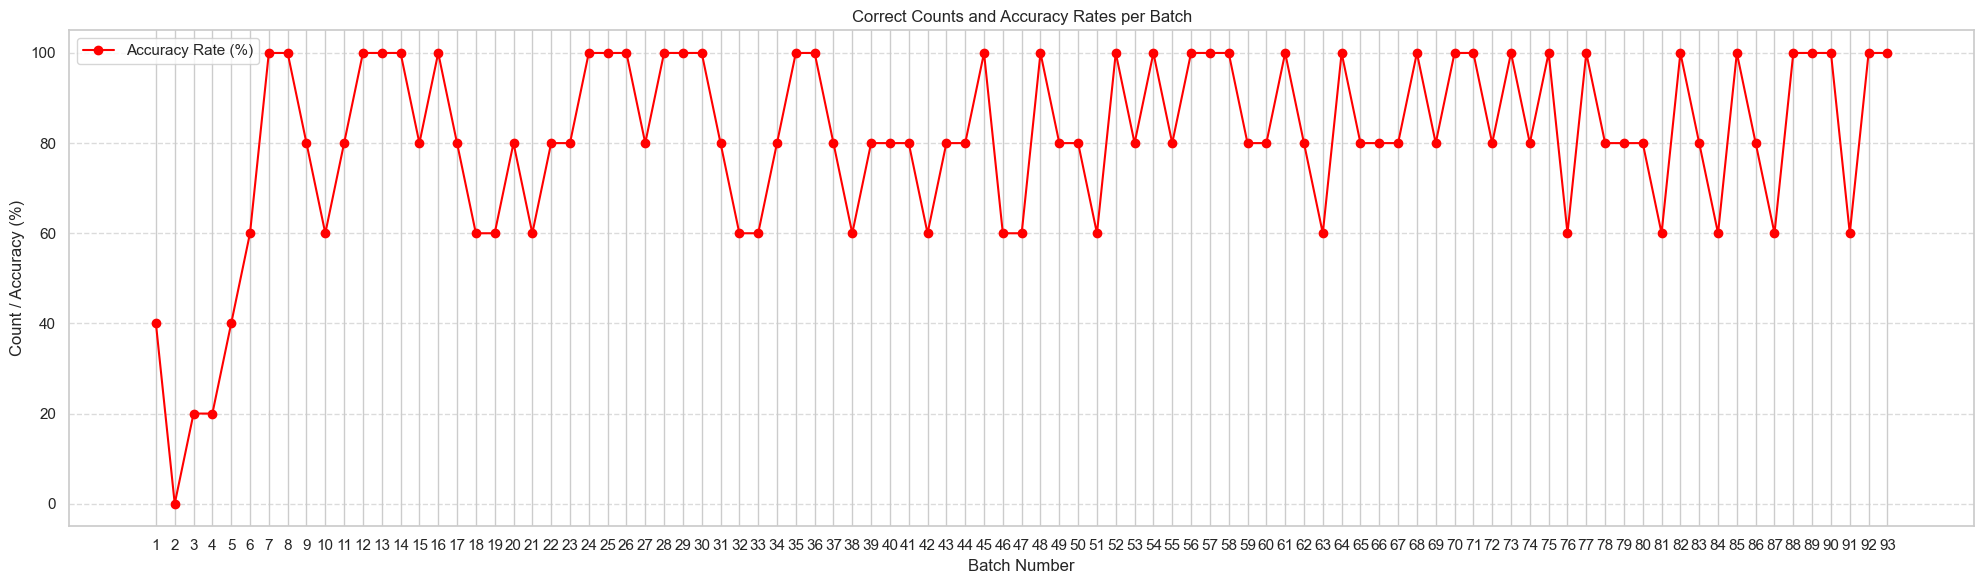

In [ ]:
visualize_accuracy(optimized_prompt.accuarcy_data)